In [22]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import ttest_ind
from IPython.display import display, Markdown

In [11]:
# Load enriched data
with open("/Users/hugomoreno/thesis-hallucination/data/intermediate/outputs_enriched.json", "r") as f:
    data = json.load(f)

# Build DataFrame with all categories
df = pd.DataFrame(data)

# Display basic info
print("Loaded enriched data with categories:", df['category'].unique())

Loaded enriched data with categories: ['A' 'B' 'C' 'D' 'E' 'F']


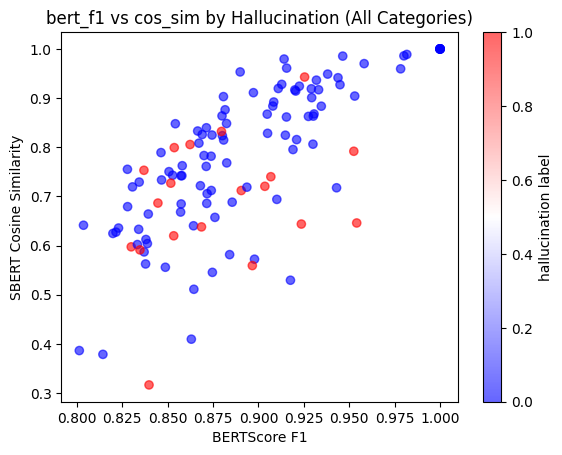

In [12]:
# Scatter plot of bert_f1 vs cos_sim colored by hallucination label
plt.figure()
plt.scatter(df['bert_f1'], df['cos_sim'], c=df['hallucination'], cmap='bwr', alpha=0.6)
plt.xlabel('BERTScore F1')
plt.ylabel('SBERT Cosine Similarity')
plt.title('bert_f1 vs cos_sim by Hallucination (All Categories)')
plt.colorbar(label='hallucination label')
plt.show()

<Figure size 640x480 with 0 Axes>

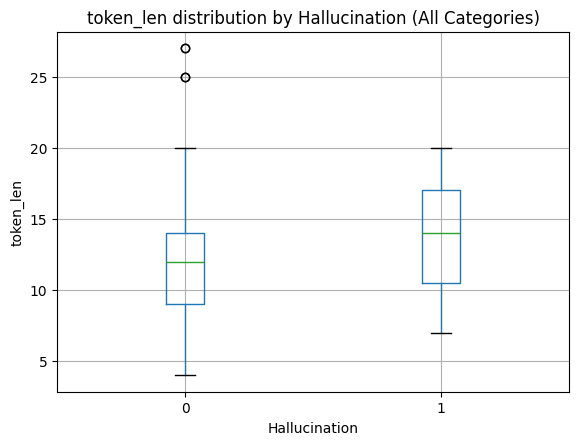

<Figure size 640x480 with 0 Axes>

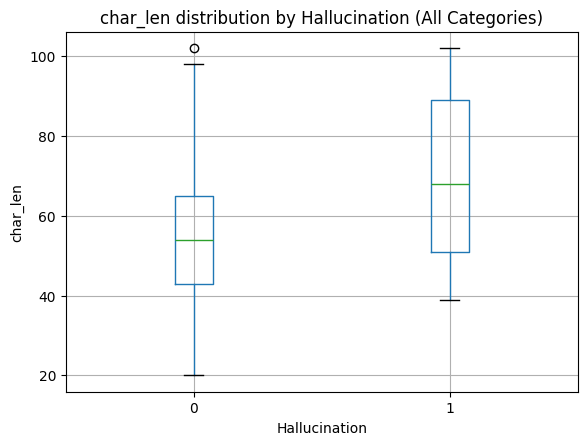

<Figure size 640x480 with 0 Axes>

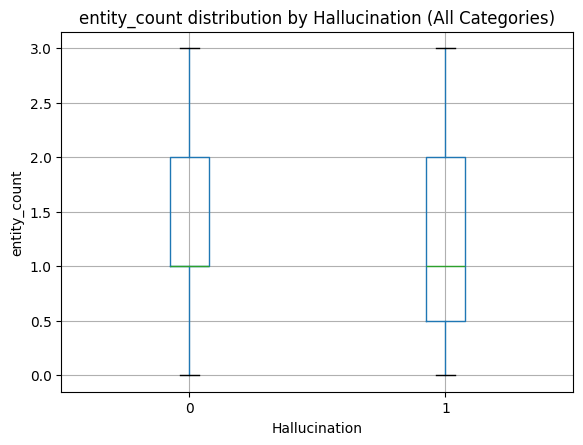

<Figure size 640x480 with 0 Axes>

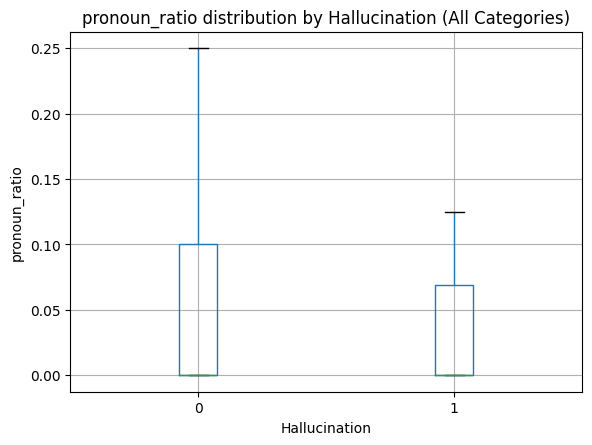

<Figure size 640x480 with 0 Axes>

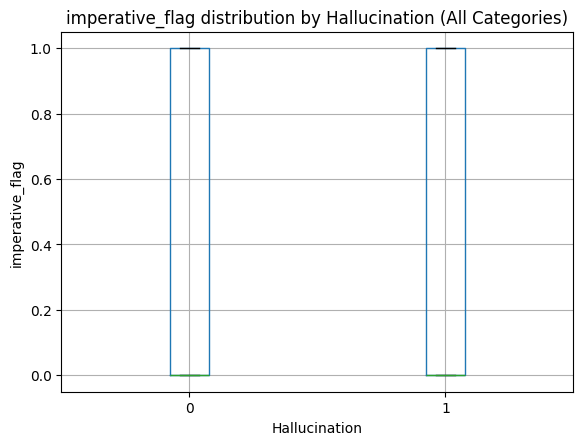

<Figure size 640x480 with 0 Axes>

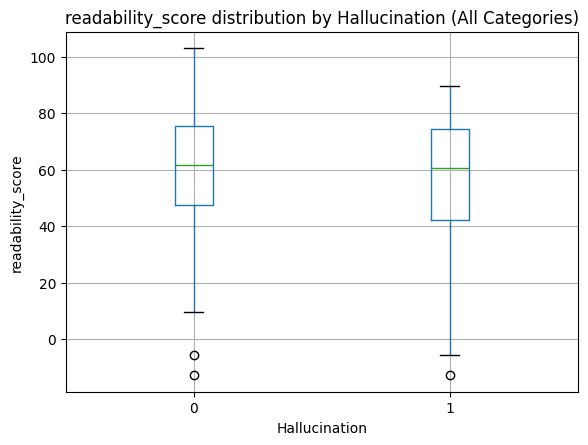

<Figure size 640x480 with 0 Axes>

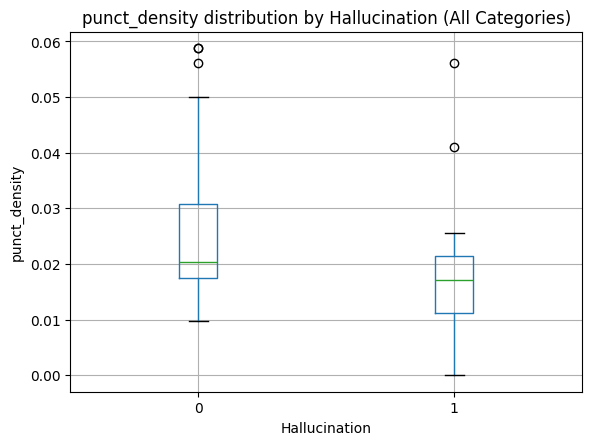

<Figure size 640x480 with 0 Axes>

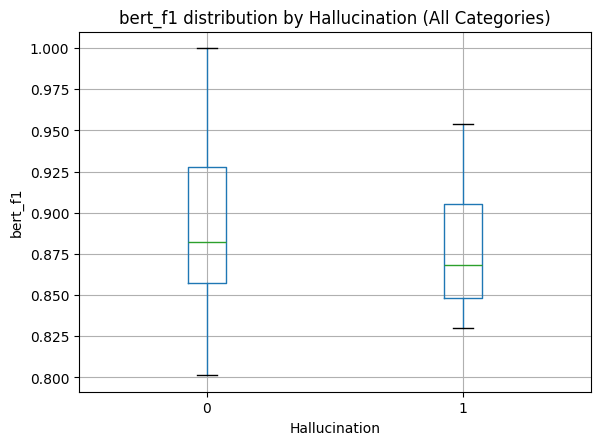

<Figure size 640x480 with 0 Axes>

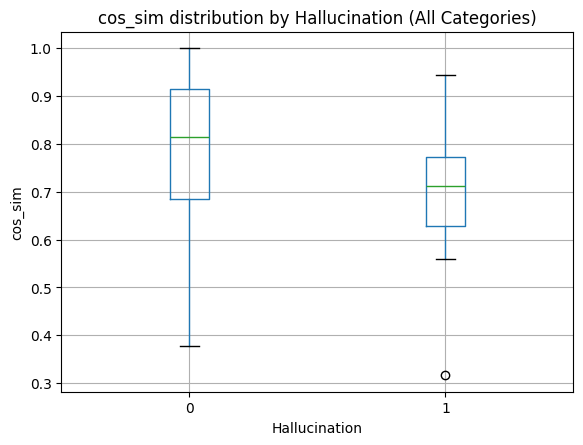

In [13]:
# Prompt-level numeric features
prompt_features = [
    'token_len', 'char_len', 'entity_count',
    'pronoun_ratio', 'imperative_flag',
    'readability_score', 'punct_density',
    'bert_f1', 'cos_sim'
]

# Boxplots of each feature by hallucination label
for feat in prompt_features:
    plt.figure()
    df.boxplot(column=feat, by='hallucination')
    plt.title(f'{feat} distribution by Hallucination (All Categories)')
    plt.suptitle('')
    plt.xlabel('Hallucination')
    plt.ylabel(feat)
    plt.show()

In [16]:
# Summary statistics
stats = df.groupby('hallucination')[prompt_features].agg(['mean', 'std', 'count'])
print("Summary statistics by hallucination label:")
print(stats)

Summary statistics by hallucination label:
               token_len                   char_len                   \
                    mean       std count       mean        std count   
hallucination                                                          
0              11.920792  4.649050   101  55.059406  18.739702   101   
1              13.842105  4.259149    19  70.315789  20.867446    19   

              entity_count                 pronoun_ratio  ...  \
                      mean       std count          mean  ...   
hallucination                                             ...   
0                 1.336634  0.815809   101      0.061242  ...   
1                 1.315789  1.056863    19      0.033526  ...   

              readability_score punct_density                   bert_f1  \
                          count          mean       std count      mean   
hallucination                                                             
0                           101      0.025254

In [23]:
# Calculate summary statistics for core metrics
stats = df.groupby('hallucination')[['bert_f1', 'cos_sim']].agg(['mean', 'std', 'count'])

# Reformat MultiIndex columns
stats.columns = ['_'.join(col) for col in stats.columns]

# Reset index for display
stats = stats.reset_index().rename(columns={'hallucination': 'hallucination_label'})

# Display as a formatted markdown table
md_table = stats.to_markdown(index=False)
display(Markdown("**Summary Statistics by Hallucination Label**"))
display(Markdown(md_table))

**Summary Statistics by Hallucination Label**

|   hallucination_label |   bert_f1_mean |   bert_f1_std |   bert_f1_count |   cos_sim_mean |   cos_sim_std |   cos_sim_count |
|----------------------:|---------------:|--------------:|----------------:|---------------:|--------------:|----------------:|
|                     0 |       0.893466 |     0.049806  |             101 |       0.78859  |      0.149944 |             101 |
|                     1 |       0.879363 |     0.0396575 |              19 |       0.690605 |      0.132451 |              19 |

In [17]:
# Statistical significance tests for numeric features
print("\nT-tests for numeric features between hallucination groups:")
for feat in prompt_features:
    grp0 = df[df['hallucination'] == 0][feat]
    grp1 = df[df['hallucination'] == 1][feat]
    if len(grp0) > 1 and len(grp1) > 1:
        t_stat, p_val = ttest_ind(grp0, grp1, equal_var=False)
        print(f"{feat}: t={t_stat:.2f}, p={p_val:.3f}")
    else:
        print(f"{feat}: not enough data for test")


T-tests for numeric features between hallucination groups:
token_len: t=-1.78, p=0.087
char_len: t=-2.97, p=0.007
entity_count: t=0.08, p=0.936
pronoun_ratio: t=2.30, p=0.027
imperative_flag: t=-0.12, p=nan
readability_score: t=1.25, p=0.224
punct_density: t=2.08, p=0.049
bert_f1: t=1.36, p=0.184
cos_sim: t=2.89, p=0.007


In [15]:
# Categorical features analysis
print("\nQuestion type distribution by hallucination:")
print(pd.crosstab(df['question_type'], df['hallucination']))
print("\nAmbiguity flag distribution by hallucination:")
print(pd.crosstab(df['ambiguity_flag'], df['hallucination']))


Question type distribution by hallucination:
hallucination   0  1
question_type       
what           27  3
who            12  0

Ambiguity flag distribution by hallucination:
Empty DataFrame
Columns: []
Index: []


In [18]:
# Baseline threshold evaluations
print("\nBaseline evaluations:")
for t in [0.85, 0.90]:
    preds = (df['bert_f1'] < t).astype(int)
    acc = accuracy_score(df['hallucination'], preds)
    f1 = f1_score(df['hallucination'], preds)
    print(f"BERT F1 < {t}: Acc = {acc:.2f}, F1 = {f1:.2f}")


Baseline evaluations:
BERT F1 < 0.85: Acc = 0.72, F1 = 0.23
BERT F1 < 0.9: Acc = 0.47, F1 = 0.29


In [19]:
# Combined threshold rule
preds_comb = ((df['bert_f1'] < 0.90) | (df['cos_sim'] < 0.75)).astype(int)
acc_c = accuracy_score(df['hallucination'], preds_comb)
f1_c = f1_score(df['hallucination'], preds_comb)
print(f"\nCombined rule (F1<0.90 or cos<0.75): Acc = {acc_c:.2f}, F1 = {f1_c:.2f}")


Combined rule (F1<0.90 or cos<0.75): Acc = 0.47, F1 = 0.35
